In [31]:
import numpyro
numpyro.set_host_device_count(4)
import bsts
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.style.use('ggplot')
%matplotlib inline
import pandas as pd
import numpy as np

This is the traffic dataset from Kaggle: https://www.kaggle.com/fedesoriano/traffic-prediction-dataset

In [2]:
df = pd.read_csv('/Users/batisengul/Downloads/traffic.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')
df['y']  = np.log(df['Vehicles'])
frame = pd.pivot_table(df, index='DateTime', values='y', columns='Junction').dropna()
frame.head()

Junction,1,2,3,4
DateTime,,,,
2017-01-01 00:00:00,3.295837,1.945910,2.302585,1.098612
2017-01-01 01:00:00,3.135494,2.197225,1.791759,0.000000
2017-01-01 02:00:00,2.833213,1.386294,1.945910,1.386294
2017-01-01 03:00:00,2.772589,1.386294,1.945910,1.386294
2017-01-01 04:00:00,2.772589,1.791759,1.609438,0.693147


To see what the seasonality is we take a look at the auto-correlation of the first junction.

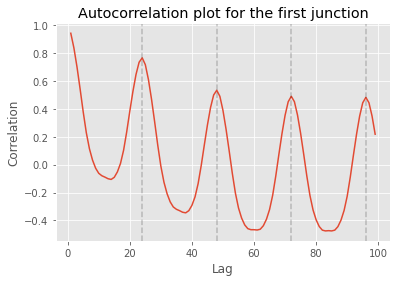

In [32]:
autocorr = {
    lag: np.corrcoef(frame.iloc[lag:, 0], frame.iloc[:-lag, 0])[0, 1]
    for lag in np.arange(1, 100)
}
autocorr = pd.Series(autocorr)
ax = autocorr.plot()
ax.set_title('Autocorrelation plot for the first junction')
ax.set_xlabel('Lag')
ax.set_ylabel('Correlation')
for i in range(24, 100, 24):
    ax.axvline(i, c='black', linestyle='--', alpha=0.2)

We can see that the seasonality is 24 which makes sense since the traffic reports are reported hourly.

Fitting the below model, we use the other junctions an hour before to make the predictions for the first junction.

In [4]:
train_len = 24 * 10
test_len = 24 * 5

frame_sub = frame.iloc[-train_len - test_len:].values


y_train_test = frame_sub[:, 0]

# Train set
y_train = y_train_test[:train_len]

model = bsts.BSTS(seasonality=24)
model.fit(y_train)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

(<Figure size 864x1008 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Time series'}>,
        <AxesSubplot:title={'center':'Trend'}>,
        <AxesSubplot:title={'center':'Change in trend'}>,
        <AxesSubplot:title={'center':'Seasonality'}>], dtype=object))

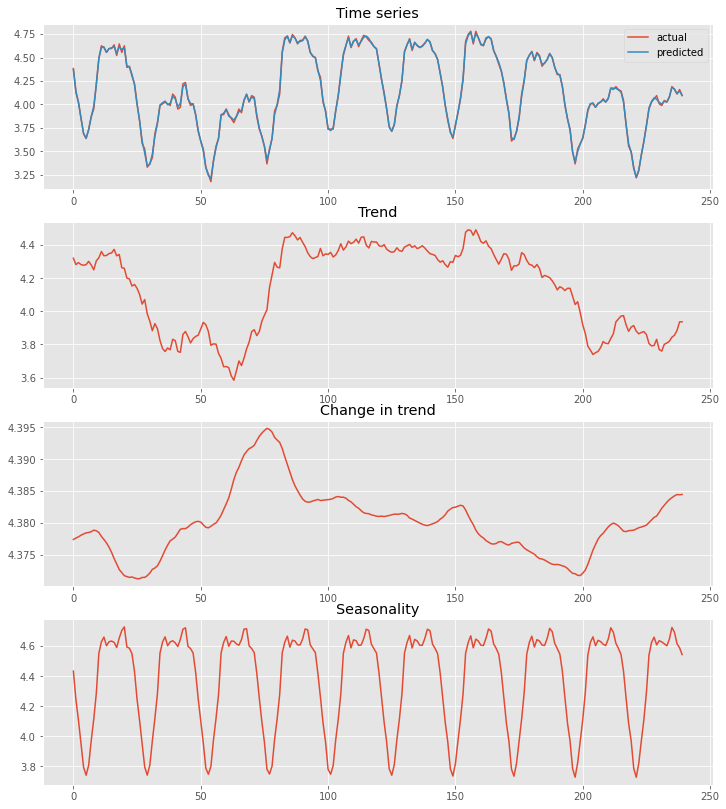

In [5]:
model.plot() # In-sample analytics to see how the fit is

We can get predictions out of the model. The `predict(k)` method will output `(num_samples, k)` matrix for the next `k` steps.

In [6]:
model.predict(10).shape

(8000, 10)

A convenient plotting method is helpful when trying to visualise the OOS performance of the model.

(<Figure size 720x288 with 1 Axes>, <AxesSubplot:>)

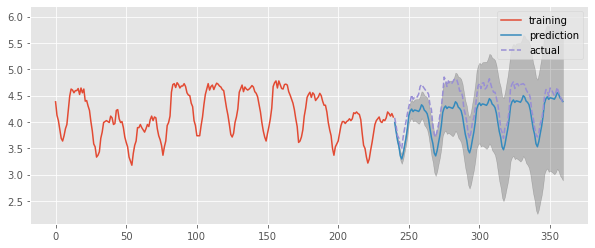

In [7]:
y_test = y_train_test[-test_len:]
model.plot_future(y_test)

We can also run the same model with co-variates which we take to be other junctions. In `bsts` this uses the Finnish horseshoe prior which should be robust to noise.

(<Figure size 720x288 with 1 Axes>, <AxesSubplot:>)

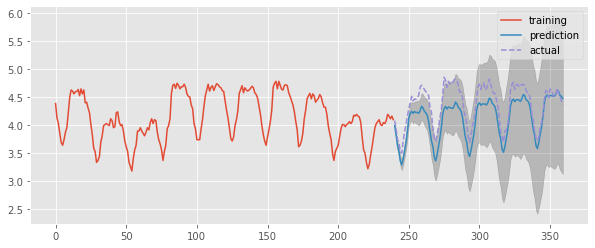

In [12]:
X_train_test = frame_sub[:, 1:]
# Add some random covariates
state = np.random.RandomState(seed=1234)
X_random = state.normal(size=(len(X_train_test), 20))
X_train_test = np.concatenate([X_train_test, X_random], axis=1)

# Train set
state = np.random.RandomState(seed=1234)
X_train = X_train_test[:train_len, :]


model = bsts.BSTS(seasonality=24)
model.fit(y_train, X_train)

# Note that the below method will use the information in X_test
X_test = X_train_test[-test_len:, :]
model.plot_future(y_test, X_test)

<AxesSubplot:>

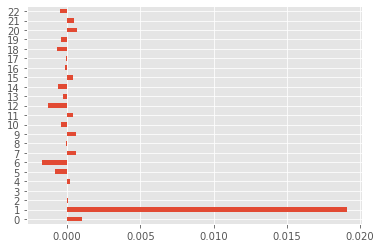

In [20]:
pd.Series(model.samples['beta'].mean(axis=0)).plot(kind='barh')

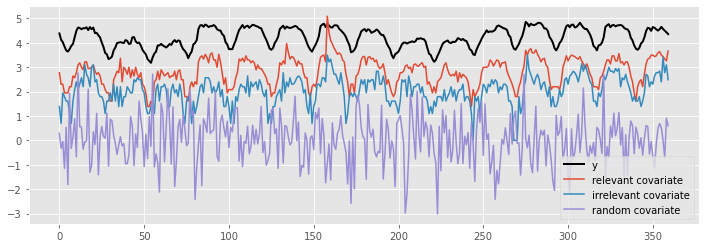

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_train_test, label='y', c='black', linewidth=2.0)
ax.plot(X_train_test[:, 1], label='relevant covariate')
ax.plot(X_train_test[:, 2], label='irrelevant covariate')
ax.plot(X_train_test[:, 20], label='random covariate')
ax.legend()